# Import Dependencies

In [67]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import deepgraph as dg
from mpl_toolkits.basemap import Basemap

%matplotlib inline

plt.style.use("ggplot")

# Selecting Data From the Database

In [2]:
# Create the connection with the database
connection = psycopg2.connect(dbname='geocenter',
                              user='vmtai', 
                              host='cslvm74.csc.calpoly.edu', 
                              password='vmtai')

cur = connection.cursor()
 
query = """
SELECT
  A.id,
  A.version,
  B.id,
  B.version,
  B.author,
  ST_X(A.point),
  ST_Y(A.point),
  ST_X(B.point),
  ST_Y(B.point),
  ST_Distance(A.point, B.point) as dist
FROM (SELECT
        C.id,
        C.version,
        C.point,
        D.timestamp,
        D.author
      FROM (node C
        JOIN osm_entity D ON C.id = D.id AND C.version = D.version)
      WHERE author = 'bigalxyz123' AND extract(YEAR FROM D.timestamp) > 2016) A
  JOIN (SELECT
          N.id,
          N.version,
          N.point,
          O.author
        FROM (node N
          JOIN osm_entity O ON N.id = O.id AND N.version = O.version)
        WHERE extract(YEAR FROM O.timestamp) > 2016 and author != 'bigalxyz123') B ON ST_DWithin(A.point, B.point, 500)
where A.id != B.id limit 500000;
"""
cur.execute(query)
queried_data = cur.fetchall()

# Creating the Deep Graph

In [3]:
# Load the data into a pandas dataframe
youth_data = pd.DataFrame(queried_data, columns = ["A_id", "A_version", "B_id", 
                                                   "B_version", "B_author","A_lat", "A_lon", 
                                                   "B_lat", "B_lon", "Distance"])

In [4]:
youth_data.head()

,A_id,A_version,B_id,B_version,B_author,A_lat,A_lon,B_lat,B_lon,Distance
0,772973076,2,4906132454,1,Hills95,54.217106,-2.591935,-17.909742,30.930817,79.536515
1,772973076,2,4782026882,1,prosper1994,54.217106,-2.591935,-19.155132,28.124201,79.542230
2,772973076,2,4782026881,1,prosper1994,54.217106,-2.591935,-19.155131,28.124253,79.542249
3,772973076,2,4782026880,1,prosper1994,54.217106,-2.591935,-19.155200,28.124253,79.542313
4,772973076,2,4782026883,1,prosper1994,54.217106,-2.591935,-19.155200,28.124202,79.542293


Drop some of the columns I don't. need I may work with these columns in the future, so I left the query as is.

In [5]:
youth_data.drop(["A_id", "A_version", "B_version", 
                 "A_lat", "A_lon", "Distance"], axis = 1, 
                inplace = True)

After some trial and error, I realized that for 5000 nodes, it was creating 12 million edges and my computer was unable to plot it. 

In [14]:
subset_youth_data = youth_data.sample(100)

In [15]:
graph = dg.DeepGraph(subset_youth_data)

Below I am creating the functions on how to connect each edge. I calculate the lat and lon distane from one point to the next and then I select only users that are within 90m of one another.

In [16]:
def calc_lat(B_lat_s, B_lat_t):
    dlat = B_lat_s - B_lat_t
    return dlat

In [17]:
def distance(dlat, B_lon_s, B_lon_t):
    dlon = B_lon_s - B_lon_t
    dist = np.sqrt(dlat**2 + dlon**2)
    return dlon, dist

In [18]:
def lat_selector(dlat, sources, targets):
    return sources, targets

I tried to reduce the selection criteria, but there were some errors. I will be trying to fix this in the next meeting.

In [19]:
def dist_selector(dist, sources, targets):
    dista = np.abs(dist)
    sources = sources[dista <= 90]
    targts = targets[dista <= 90]
    return sources, targets

In [20]:
# Create the graphs based on what criteria to connect and select
graph.create_edges(connectors = [calc_lat, distance],
                   selectors = [lat_selector, dist_selector])

In [75]:
graph.e.head()

dist       dlat       dlon
s      t                                      
275811 341339  33.469697 -24.509218  22.792957
       434646   2.462237   1.152458  -2.175880
       460556   0.806177   0.573071  -0.567019
       47067    1.984723   0.969817  -1.731641
       465021   0.738849   0.429475  -0.601206

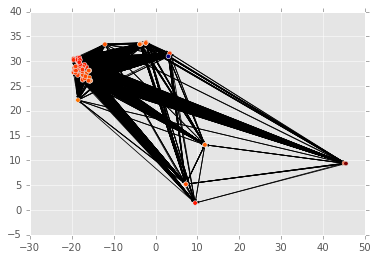

In [44]:
# Plotting the lat and lon as a scatterplot
obj = graph.plot_2d("B_lat", "B_lon", edges = True,
                kwds_scatter = {'c': graph.v.B_id})


In [64]:
# Parameters for the map graph
kwds_basemap = {'llcrnrlon': graph.v.B_lon.min() - 40,
                'urcrnrlon': graph.v.B_lon.max() + 20,
                'llcrnrlat': graph.v.B_lat.min() - 20,
                'urcrnrlat': graph.v.B_lat.max() + 20,
                'resolution': 'i'}

kwds_scatter = {'s': 1.5, 
                'c': graph.v.B_id,
                'edgecolors':'none'}

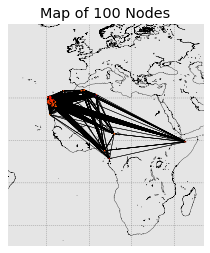

In [77]:
# Mapping the nodes
objs = graph.plot_map("B_lat", "B_lon",
                       edges = True,
                       kwds_basemap = kwds_basemap,
                       kwds_scatter = kwds_scatter)

objs['m'].drawcoastlines(linewidth=.3)
objs['m'].drawparallels(range(-50, 50, 20), linewidth=.2)
objs['m'].drawmeridians(range(0, 360, 20), linewidth=.2)
objs['ax'].set_title("Map of 100 Nodes")
plt.savefig("map_of_100_nodes.png")

I wanted to make a graph which each user to other users dependent on their nodes. In future exploration, I will be adding time into the analysis. Picking the users based on the when they started making a node and then calculating how far away they are from other users and how close they are in proximity of time.